<a href="https://colab.research.google.com/github/martydom/Tomato-Detection-Using-RetinaNet/blob/main/Training_RetinaNET_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install dependencies: 
!pip install -q pyyaml==5.1 pycocotools==2.0.1 imgaug==0.2.5
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 2.7MB/s 
     |████████████████████████████████| 563kB 7.4MB/s 
1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

     |████████████████████████████████| 6.6MB 28.4MB/s 
     |████████████████████████████████| 2.2MB 3.9MB/s 


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

# Train on the RetinaNET Dataset

In [ ]:
!gdown --id 1johg1Plrb4q0difgxiiduq2pgcbts34i

Downloading...
From: https://drive.google.com/uc?id=1johg1Plrb4q0difgxiiduq2pgcbts34i
To: /content/Tomato.coco.zip
66.4MB [00:00, 108MB/s] 


In [ ]:
!unzip -q Tomato.coco.zip

In [ ]:
#As our dataset is in COCO format we use the following lines

from detectron2.data.datasets import register_coco_instances
register_coco_instances("tomato_train", {}, '/content/train/_annotations.coco.jsonmodified.json', "/content/train/")
register_coco_instances("tomato_val", {}, "/content/valid/_annotations.coco.jsonmodified.json", "/content/valid/")
register_coco_instances("tomato_test",{},"/content/test/_annotations.coco.jsonmodified.json","/content/test")

WARNING [08/19 08:07:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/19 08:07:36 d2.data.datasets.coco]: Loaded 873 images in COCO format from /content/train/_annotations.coco.jsonmodified.json


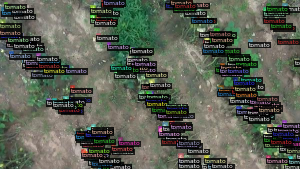

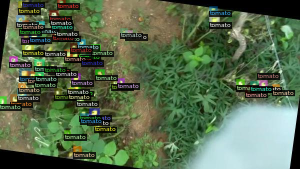

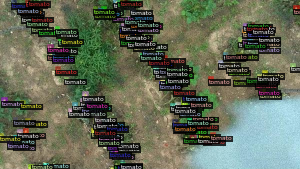

In [ ]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("tomato_train")
dataset_dicts = DatasetCatalog.get("tomato_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
anchor_sizes = eval("[[x, x * 2**(1.0/3), x * 2**(2.0/3) ] for x in [32, 64, 128, 256, 512 ]]")
print(anchor_sizes)

[[32, 40.31747359663594, 50.79683366298238], [64, 80.63494719327188, 101.59366732596476], [128, 161.26989438654377, 203.18733465192952], [256, 322.53978877308754, 406.37466930385904], [512, 645.0795775461751, 812.7493386077181]]


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()

#Using RetinaNet
cfg.MODEL.META_ARCHITECTURE = "RetinaNet"
cfg.MODEL.BACKBONE.NAME = "build_retinanet_resnet_fpn_backbone"
cfg.MODEL.RESNETS.OUT_FEATURES = ["res3", "res4", "res5"]
#cfg.MODEL.ANCHOR_GENERATOR.SIZES = anchor_sizes
cfg.MODEL.FPN.IN_FEATURES = ["res3", "res4", "res5"]
cfg.MODEL.RETINANET.IOU_THRESHOLDS = [0.4,0.5]
cfg.MODEL.RETINANET.IOU_LABELS = [0, -1, 1]
cfg.MODEL.RETINANET.NUM_CLASSES = 1

cfg.DATASETS.TRAIN = ("tomato_train",)
cfg.DATASETS.TEST = ("tomato_val",)

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.01
#cfg.SOLVER.STEPS = (3000,4000)
#cfg.OUTPUT_DIR = "retinanet_train"
cfg.SOLVER.MAX_ITER = 2000
cfg.SOLVER.NESTEROV = True

cfg.INPUT.MIN_SIZE_TRAIN = (640, 672, 704, 736, 768, 800)

cfg.VERSION = 2

cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_50_FPN_3x/190397829/model_final_5bd44e.pkl"
cfg.MODEL.RESNETS.DEPTH = 50
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.CHECKPOINT_PERIOD = 500

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
torch.cuda.empty_cache()
os.makedirs(cfg.OUTPUT_DIR,exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[08/19 08:11:15 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

model_final_5bd44e.pkl: 152MB [00:13, 10.9MB/s]                           
Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (15, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.bbox_pred.weight' to the model due to incompatible shapes: (36, 256, 3, 3) in the checkpoint but (60, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.bbox_pred.bias' to the model due to incompatible shapes: (36,) in the checkpoint but (60,) in the model! You might want to double check if this is expected.
Skip loading parameter 'anchor_generator.cell_anchors.0' to the model due to incompatible shapes: (9, 4) in the checkpoint but (15, 4) 

[08/19 08:11:36 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


[08/19 08:12:09 d2.utils.events]:  eta: 0:54:06  iter: 19  total_loss: 4.193  loss_cls: 1.108  loss_box_reg: 2.815  time: 1.6017  data_time: 0.0180  lr: 0.000200  max_mem: 3833M
[08/19 08:12:42 d2.utils.events]:  eta: 0:54:25  iter: 39  total_loss: 1.212  loss_cls: 0.421  loss_box_reg: 0.774  time: 1.6262  data_time: 0.0061  lr: 0.000400  max_mem: 3841M
[08/19 08:13:16 d2.utils.events]:  eta: 0:54:36  iter: 59  total_loss: 0.998  loss_cls: 0.344  loss_box_reg: 0.640  time: 1.6400  data_time: 0.0068  lr: 0.000599  max_mem: 4037M
[08/19 08:13:49 d2.utils.events]:  eta: 0:53:56  iter: 79  total_loss: 0.849  loss_cls: 0.324  loss_box_reg: 0.523  time: 1.6467  data_time: 0.0071  lr: 0.000799  max_mem: 4474M
[08/19 08:14:23 d2.utils.events]:  eta: 0:53:25  iter: 99  total_loss: 0.739  loss_cls: 0.304  loss_box_reg: 0.422  time: 1.6530  data_time: 0.0062  lr: 0.000999  max_mem: 4474M
[08/19 08:14:56 d2.utils.events]:  eta: 0:52:41  iter: 119  total_loss: 0.782  loss_cls: 0.305  loss_box_reg: 

KeyboardInterrupt: ignored

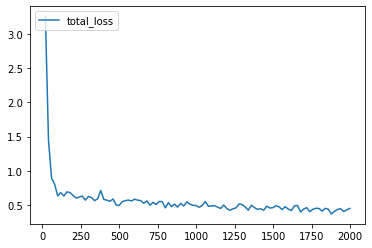

In [ ]:
import json
import matplotlib.pyplot as plt

experiment_folder = '.'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

plt.plot(
    [x['iteration'] for x in experiment_metrics], 
    [x['total_loss'] for x in experiment_metrics])
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
plt.legend(['total_loss'], loc='upper left')
plt.show()

In [ ]:
after_train_cfg = cfg.clone()
after_train_cfg.MODEL.WEIGHTS = '/content/output/model_final.pth'
after_train_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2

In [ ]:
im = cv2.imread('/content/tomato_frames/frame10.jpg')

In [ ]:
predictor = DefaultPredictor(after_train_cfg)
outputs = predictor(im)

In [ ]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes.tensor.tolist())

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')
[[1228.7274169921875, 914.1784057617188, 1265.3951416015625, 951.5755004882812], [1231.782470703125, 632.0392456054688, 1263.678466796875, 665.18310546875], [859.3513793945312, 421.4311828613281, 893.1214599609375, 456.4224548339844], [833.855712890625, 301.4858093261719, 869.9678955078125, 338.16973876953125], [899.3438110351562, 443.0697937011719, 928.8036499023438, 472.7580261230469], [1424.0755615234375, 924.6726684570312, 1439.415283203125, 940.3618774414062], [1422.312255859375, 909.1643676757812, 1438.7860107421875, 926.0313110351562], [1472.5804443359375, 1017.0809936523438, 1507.3603515625, 1052.8336181640625], [587.939636230

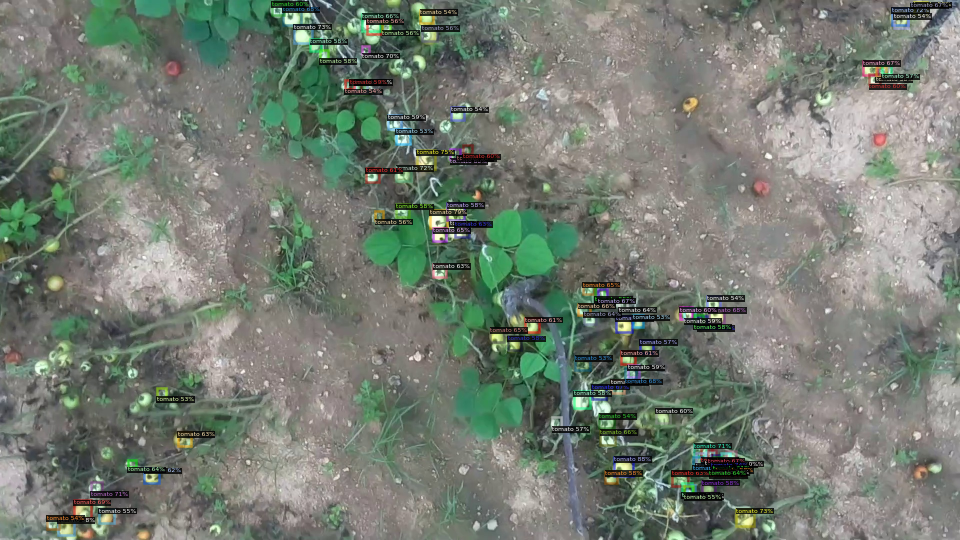

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
! rm -rf tomato_frames
!rm frame*.jpg

In [ ]:
# Load video frames for prediction of yield
!mkdir tomato_frames
import cv2
vidcap = cv2.VideoCapture('/content/drive/My Drive/Tomato crop.h264')
success,image = vidcap.read()
count = 0
success = True
while success:
  success,image = vidcap.read()
  cv2.imwrite("tomato_frames/frame%d.jpg" % count, image)     # save frame as JPEG file
  #print('Read a new frame: ', success)
  count += 1

print(count)

error: ignored

In [ ]:
#Take frames that are used for yield prediction
import glob
import os
import shutil

fps = vidcap.get(cv2.CAP_PROP_FPS)
!mkdir yield_est_frames

for idx, file in enumerate(glob.glob('/content/tomato_frames/*.jpg')):
  filename = os.path.basename(file)
  frame_no = int(filename[5:-4])
  if frame_no % fps == 0:
    shutil.copy(file,'yield_est_frames/'+filename)

mkdir: cannot create directory ‘yield_est_frames’: File exists
125
125
142
149
285
275
275
102
144
88
159
127
210
97
80
202
200
200
122
24
119
156
40
233
173
117
296
133
247
186
255
264
139
231
22
123
7
277
16
180
82
257
114
243
3
44
155
113
87
171
21
194
147
165
11
287
79
110
141
136
197
60
220
106
4
150
150
9
236
28
246
140
134
77
179
294
57
215
212
260
226
204
152
168
235
290
256
101
108
51
92
279
193
66
83
153
17
84
157
201
271
214
64
183
67
0
0
158
91
103
182
74
69
15
99
222
36
43
132
135
187
278
221
154
6
89
93
261
199
272
45
254
225
225
219
167
76
94
291
35
98
50
50
244
38
218
203
288
39
282
250
250
176
71
2
23
75
75
280
211
65
145
30
126
240
164
166
151
292
143
253
259
269
258
195
276
169
274
18
104
109
181
190
118
252
185
107
281
162
111
228
131
205
266
27
105
128
31
26
170
192
213
46
86
52
262
232
174
172
49
146
289
48
249
33
54
19
286
129
56
138
14
177
234
121
242
230
47
100
100
208
32
223
238
13
53
267
245
227
37
72
217
248
29
62
229
265
284
137
148
70
191
63
160
270
196
23

In [ ]:
all_outputs = []
all_pred_boxes = []
for idx, file in enumerate(glob.glob('/content/yield_est_frames/*.jpg')):
  im = cv2.imread(file)
  output = predictor(im)
  all_outputs.append(output)
  all_pred_boxes += outputs["instances"].pred_boxes.tensor.tolist()

In [ ]:
print(all_pred_boxes)

[[1324.9208984375, 957.217041015625, 1368.3790283203125, 997.6769409179688], [1506.0894775390625, 999.10302734375, 1533.163818359375, 1028.107666015625], [970.6080322265625, 409.3829040527344, 1010.4104614257812, 448.1956787109375], [1336.1875, 732.7501220703125, 1368.5101318359375, 764.294189453125], [941.3955078125, 538.2845458984375, 972.6478881835938, 570.2697143554688], [334.962890625, 964.8108520507812, 368.44879150390625, 999.2979125976562], [1189.6220703125, 865.1648559570312, 1215.81005859375, 892.275390625], [397.8077697753906, 885.6727294921875, 428.7568054199219, 917.9185791015625], [808.9818115234375, 426.8641662597656, 834.7844848632812, 454.6233825683594], [127.48143005371094, 317.15380859375, 160.55709838867188, 349.9670715332031], [859.2022094726562, 333.0691833496094, 892.4295043945312, 365.7226257324219], [1434.3966064453125, 1040.4384765625, 1471.6925048828125, 1076.014892578125], [1357.9554443359375, 651.3027954101562, 1384.181884765625, 678.8143310546875], [130.96

In [ ]:
total_yield = 0.0 # in grams
all_area = []
for pred_box in all_pred_boxes:
  x_diff = pred_box[2] - pred_box[0]
  y_diff = pred_box[3] - pred_box[1]

  area = x_diff * y_diff
  all_area.append(area)
  if area > 0 and area < 500:
    total_yield += 70 
    continue
  elif area < 1100:
    total_yield += 120
    continue
  else:
    total_yield += 150

print('Total yield is {0} kgs'.format(total_yield/1000))

Total yield is 150.0


In [ ]:
print(all_area)

[1758.3115850016475, 785.2814727723598, 1544.8427153583616, 1019.587276622653, 999.6126508526504, 1154.8302910774946, 709.9703641831875, 997.977948948741, 716.2619905807078, 1085.320601973217, 1084.9855602681637, 1326.8543984889984, 721.5296507105231, 1235.785180949606, 313.76957380771637, 1277.6835673190653, 841.9121916759759, 1187.133934609592, 1103.4500634670258, 889.9207698404789, 1279.6513804644346, 738.9652368426323, 1172.2251173108816, 719.2703779935837, 1187.7553603872657, 873.7826648652554, 1323.7506665289402, 1315.0195573344827, 1255.3980910182, 961.8068743869662, 1061.1816424578428, 1256.7428724169731, 746.1541375815868, 897.0082842595875, 569.4576767832041, 430.8896408006549, 1191.5212896359153, 1131.4239356070757, 870.7108967006207, 1293.3507658466697, 848.3455713912845, 1054.3585708737373, 1480.7631966634654, 416.9555122256279, 1356.4320802092698, 1274.275559714064, 1082.6602756977081, 998.0823919177055, 1211.9686557650566, 1284.1416629850864, 1246.8909565359354, 812.3030

In [ ]:
from statistics import mean, median

print('max',max(all_area))
print('min',min(all_area))
print('avg',mean(all_area))
print('median',median(all_area))

max 1815.625416867435
min 292.97940853238106
avg 944.283349527087
median 969.7402999103069
